In [8]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, \
GBTClassifier, MultilayerPerceptronClassifier, LinearSVC, OneVsRest, NaiveBayes, FMClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

In [3]:
%%time

df = spark.read.csv("out.csv", header=True, inferSchema=True)
Assembler = VectorAssembler(inputCols=['PC%d'%(i) for i in range (1,1001)], outputCol="features")
df_features = Assembler.transform(df)
df = df_features.select("features", "label")
df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[38.2528,-12.7831...|    0|
|[39.827736,-8.731...|    0|
|[32.10166,13.4068...|    0|
|[32.34024,-12.503...|    0|
|[37.411884,-18.80...|    0|
|[31.38527,1.65564...|    0|
|[39.42829,-10.564...|    0|
|[28.69016,-32.621...|    0|
|[37.675114,-5.514...|    0|
|[38.25259,-12.451...|    0|
|[31.108402,6.9113...|    0|
|[31.290989,18.632...|    0|
|[33.466557,15.921...|    0|
|[34.797447,-16.39...|    0|
|[30.72191,0.63299...|    0|
|[31.816153,-22.34...|    0|
|[31.015968,-23.15...|    0|
|[39.90562,-1.3906...|    0|
|[31.377953,-13.10...|    0|
|[41.82224,5.30159...|    0|
+--------------------+-----+
only showing top 20 rows

Wall time: 9.6 s


In [4]:
%%time

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
(train, test) = df.randomSplit([0.8, 0.2])

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(train)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

Coefficients: (1000,[],[])
Intercept: -0.00897216863315598
Multinomial coefficients: 2 X 1000 CSRMatrix

Multinomial intercepts: [0.004485362866238553,-0.004485362866238553]
objectiveHistory:
0.6931371181849493
+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 0.5
Wall time: 14.4 s


LogisticRegression_6857a93f712e

In [15]:
%%time

accuracies = []
for i in range(5):
    # Train a DecisionTree model.
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
    (train, test) = df.randomSplit([0.8, 0.2])

    # Train model.  This also runs the indexers.
    model = dt.fit(train)
    
    # Make predictions.
    predictions = model.transform(test)

    # Select example rows to display.
    # predictions.select("prediction", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g " % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.6995305164319249
Test Error = 0.300469 
Test set accuracy = 0.6947852760736196
Test Error = 0.305215 
Test set accuracy = 0.6770428015564203
Test Error = 0.322957 
Test set accuracy = 0.6791730474732006
Test Error = 0.320827 
Test set accuracy = 0.7020785219399538
Test Error = 0.297921 
Average accuracy = 0.6905220326950239
Wall time: 45.4 s


In [6]:
%%time

accuracies = []
for i in range(5):
    # Train a RandomForest model.
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
    (train, test) = df.randomSplit([0.8, 0.2])

    # Train model.  This also runs the indexers.
    model = rf.fit(train)

    # Make predictions.
    predictions = model.transform(test)

    # Select example rows to display.
    # predictions.select("prediction", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g" % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.6540832049306625
Test Error = 0.345917
Test set accuracy = 0.6837136113296617
Test Error = 0.316286
Test set accuracy = 0.6933333333333334
Test Error = 0.306667
Test set accuracy = 0.6561051004636785
Test Error = 0.343895
Test set accuracy = 0.6909227306826706
Test Error = 0.309077
Average accuracy = 0.6756315961480013
Wall time: 48 s


In [7]:
%%time

accuracies = []
for i in range(5):
    # Train a GBT model.
    gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
    (train, test) = df.randomSplit([0.8, 0.2])

    # Train model.  This also runs the indexers.
    model = gbt.fit(train)

    # Make predictions.
    predictions = model.transform(test)

    # Select example rows to display.
    # predictions.select("prediction", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g" % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.7754777070063694
Test Error = 0.224522
Test set accuracy = 0.7321848081440877
Test Error = 0.267815
Test set accuracy = 0.7496159754224271
Test Error = 0.250384
Test set accuracy = 0.6864274570982839
Test Error = 0.313573
Test set accuracy = 0.7448818897637796
Test Error = 0.255118
Average accuracy = 0.7377175674869896
Wall time: 2min


In [8]:
%%time

accuracies = []
for i in range(5):
    # specify layers for the neural network:
    # input layer of size 1000 (features), two intermediate of size 512 and 256
    # and output of size 2 (classes)
    layers = [1000, 512, 256, 2]

    # create the trainer and set its parameters
    trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
    (train, test) = df.randomSplit([0.8, 0.2])

    # train the model
    model = trainer.fit(train)

    # compute accuracy on the test set
    result = model.transform(test)
    predictionAndLabels = result.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    accuracy = evaluator.evaluate(predictionAndLabels)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g " % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.9805194805194806
Test Error = 0.0194805 
Test set accuracy = 0.9798761609907121
Test Error = 0.0201238 
Test set accuracy = 0.9829325058184639
Test Error = 0.0170675 
Test set accuracy = 0.9796747967479674
Test Error = 0.0203252 
Test set accuracy = 0.9849510910458992
Test Error = 0.0150489 
Average accuracy = 0.9815908070245045
Wall time: 8min 43s


In [9]:
%%time

accuracies = []
for i in range(5):
    lsvc = LinearSVC(maxIter=10, regParam=0.1)
    (train, test) = df.randomSplit([0.8, 0.2])

    # Fit the model
    lsvcModel = lsvc.fit(train)

    # Print the coefficients and intercept for linear SVC
    #print("Coefficients: " + str(lsvcModel.coefficients))
    #print("Intercept: " + str(lsvcModel.intercept))

    # Make predictions.
    predictions = lsvcModel.transform(test)

    # Select example rows to display.
    # predictions.select("prediction", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g " % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.920545746388443
Test Error = 0.0794543 
Test set accuracy = 0.9273008507347255
Test Error = 0.0726991 
Test set accuracy = 0.9144215530903328
Test Error = 0.0855784 
Test set accuracy = 0.92421875
Test Error = 0.0757813 
Test set accuracy = 0.9064
Test Error = 0.0936 
Average accuracy = 0.9185773800427002
Wall time: 37.6 s


In [10]:
%%time

accuracies = []
for i in range(5):
    # instantiate the base classifier.
    lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
    (train, test) = df.randomSplit([0.8, 0.2])

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(train)

    # score the model on test data.
    predictions = ovrModel.transform(test)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g" % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.9335394126738794
Test Error = 0.0664606
Test set accuracy = 0.9385692068429238
Test Error = 0.0614308
Test set accuracy = 0.946034341782502
Test Error = 0.0539657
Test set accuracy = 0.9379418695993715
Test Error = 0.0620581
Test set accuracy = 0.9445745511319282
Test Error = 0.0554254
Average accuracy = 0.9401318764061208
Wall time: 3min


In [11]:
%%time

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
df_new = df

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_new)

# rescale each feature to range [min, max].
scaledData = scalerModel.transform(df_new)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[38.2528,-12.7831...|[0.87108461447592...|
|[39.827736,-8.731...|[0.88864953527688...|
|[32.10166,13.4068...|[0.80248227956478...|
|[32.34024,-12.503...|[0.80514311073804...|
|[37.411884,-18.80...|[0.86170606008370...|
|[31.38527,1.65564...|[0.79449253673548...|
|[39.42829,-10.564...|[0.88419460037523...|
|[28.69016,-32.621...|[0.76443455742720...|
|[37.675114,-5.514...|[0.86464180737911...|
|[38.25259,-12.451...|[0.87108227239131...|
|[31.108402,6.9113...|[0.79140468777380...|
|[31.290989,18.632...|[0.79344104112040...|
|[33.466557,15.921...|[0.81770468079661...|
|[34.797447,-16.39...|[0.83254780930773...|
|[30.72191,0.63299...|[0.78709422603427...|
|[31.816153,-22.34...|[0.79929808170333...|
|[31.015968,-23.15...|[0.79037379135050...|
|[39.90562,-1.3906...|[0.88951815869501...|
|[31.377953,-13.10...|[0.7944

In [12]:
%%time

accuracies = []
for i in range(5):
    # create the trainer and set its parameters
    nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="label", featuresCol="scaledFeatures")

    (train_nb, test_nb) = scaledData.randomSplit([0.8, 0.2])

    # train the model
    model = nb.fit(train_nb)

    # select example rows to display.
    predictions = model.transform(test_nb)
    #predictions.show()

    # compute accuracy on the test set
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = " + str(accuracy))
    print("Test Error = %g" % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.8581847649918962
Test Error = 0.141815
Test set accuracy = 0.8829536527886881
Test Error = 0.117046
Test set accuracy = 0.8554021121039805
Test Error = 0.144598
Test set accuracy = 0.8629600626468285
Test Error = 0.13704
Test set accuracy = 0.8693227091633466
Test Error = 0.130677
Average accuracy = 0.8657646603389481
Wall time: 17.2 s


In [13]:
%%time

accuracies = []
for i in range(5):
    # Train a FM model.
    fm = FMClassifier(labelCol="label", featuresCol="features", stepSize=0.001)
    (train, test) = df.randomSplit([0.8, 0.2])

    # Train model.
    model = fm.fit(train)

    # Make predictions.
    predictions = model.transform(test)

    # Select example rows to display.
    #predictions.select("prediction", "label", "features").show(5)

    # Select (prediction, true label) and compute test accuracy
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test set accuracy = %g" % accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    accuracies.append(accuracy)
    
print("Average accuracy = " + str(sum(accuracies)/5))

Test set accuracy = 0.990861
Test Error = 0.00913938
Test set accuracy = 0.992095
Test Error = 0.00790514
Test set accuracy = 0.987997
Test Error = 0.012003
Test set accuracy = 0.992163
Test Error = 0.00783699
Test set accuracy = 0.987683
Test Error = 0.0123172
Average accuracy = 0.9901596655573386
Wall time: 11min 11s


In [7]:
import numpy as np
dt = [0.6995305164319249, 0.6947852760736196, 0.6770428015564203, 0.6791730474732006, 0.7020785219399538]
rf = [0.6540832049306625, 0.6837136113296617, 0.6933333333333334, 0.6561051004636785, 0.6909227306826706]
gbt = [0.7754777070063694, 0.7321848081440877, 0.7496159754224271, 0.6864274570982839, 0.7448818897637796]
mp = [0.9805194805194806, 0.9798761609907121, 0.9829325058184639, 0.9796747967479674, 0.9849510910458992]
svm = [0.920545746388443, 0.9273008507347255, 0.9144215530903328, 0.92421875, 0.9064]
ovr = [0.9335394126738794, 0.9385692068429238, 0.946034341782502, 0.9379418695993715, 0.9445745511319282]
nb = [0.8581847649918962, 0.8829536527886881, 0.8554021121039805, 0.8629600626468285, 0.8693227091633466]
fm = [0.990861, 0.992095, 0.987997, 0.992163, 0.987683]

avgs = [np.average(dt)*100, np.average(rf)*100, np.average(gbt)*100, np.average(mp)*100, np.average(svm)*100, np.average(ovr)*100, np.average(nb)*100, np.average(fm)*100]
stds = [np.std(dt)*100, np.std(rf)*100, np.std(gbt)*100, np.std(mp)*100, np.std(svm)*100, np.std(ovr)*100, np.std(nb)*100, np.std(fm)*100]
print(avgs)
print(stds)

[69.05220326950239, 67.56315961480013, 73.77175674869896, 98.15908070245045, 91.85773800427002, 94.01318764061209, 86.5764660338948, 99.01598]
[1.0424678457049836, 1.7076922801827457, 2.9257527616799424, 0.20420828210195163, 0.7447925138495659, 0.4588574948215963, 0.9806366916273868, 0.19525231266235957]


In [11]:
model = ["Decision Tree", "Random Forest", "Gradient Boosted Tree", "Multilayer Perceptron", "Linear SVM", "One-vs-Rest", "Naive Bayes", "FM Classifier"]
accuracies = [69.05, 67.56, 73.77, 98.16, 91.86, 94.01, 86.58, 99.02]
times = [45.4, 48, 2*60, (8*60)+43, 37.6, 3*60, 17.2+3.37, (11*60)+11]

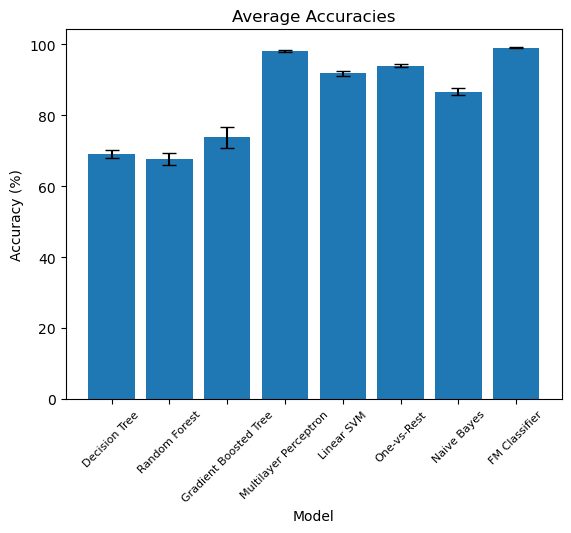

In [34]:
import matplotlib.pyplot as plt

x_axis = model
y_axis = avgs

plt.bar(x_axis, y_axis, yerr=stds, capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(size=8)
plt.xticks(rotation=45, ha='center')
plt.show()

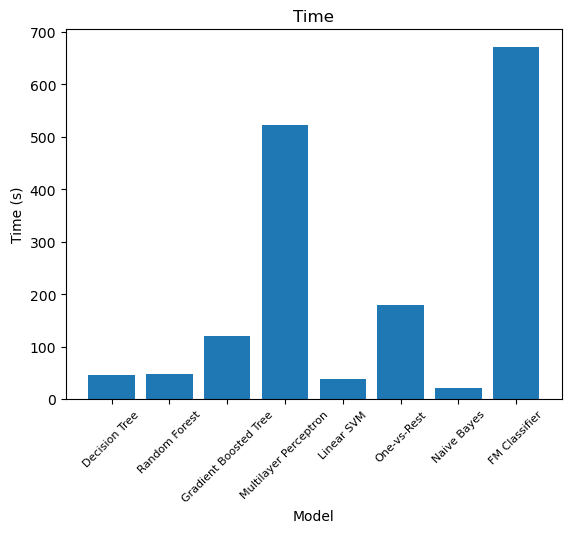

In [27]:
import matplotlib.pyplot as plt

x_axis = model
y_axis = times

plt.bar(x_axis, y_axis)
plt.title('Time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.xticks(size=8)
plt.xticks(rotation=45, ha='center')
plt.show()